In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Make project root importable
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
from src.model_training_edited import prepare_data, train_logistic_regression, train_random_forest
from src.evaluation_edited import evaluate_model, recall_at_k

In [3]:
processed_path = os.path.join(project_root, "data", "processed", "telco_churn_processed.csv")
df = pd.read_csv(processed_path)
print("df shape:", df.shape)

df shape: (7043, 28)


In [4]:
X_train, X_test, y_train, y_test, preprocessor = prepare_data(df)

In [5]:
log_model = train_logistic_regression(X_train, y_train, preprocessor)
rf_model  = train_random_forest(X_train, y_train, preprocessor)

In [6]:
log_results = evaluate_model(log_model, X_test, y_test)
rf_results  = evaluate_model(rf_model,  X_test, y_test)

print("Logistic accuracy:", log_results["accuracy"])
print("Random Forest accuracy:", rf_results["accuracy"])


Logistic accuracy: 0.7842441447835344
Random Forest accuracy: 0.7700496806245565


In [16]:
print(log_results["classification_report"] )

              precision    recall  f1-score   support

       False       0.82      0.91      0.86      1035
        True       0.63      0.45      0.53       374

    accuracy                           0.78      1409
   macro avg       0.73      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



In [21]:
print(log_results["f1"])

0.525


In [7]:
#
print("log_model:", type(log_model))
print("rf_model :", type(rf_model))

print("log_results keys:", log_results.keys())
print("rf_results  keys:", rf_results.keys())

log_model: <class 'sklearn.pipeline.Pipeline'>
rf_model : <class 'sklearn.pipeline.Pipeline'>
log_results keys: dict_keys(['roc_auc', 'pr_auc', 'accuracy', 'precision', 'recall', 'f1', 'confusion_matrix', 'classification_report'])
rf_results  keys: dict_keys(['roc_auc', 'pr_auc', 'accuracy', 'precision', 'recall', 'f1', 'confusion_matrix', 'classification_report'])


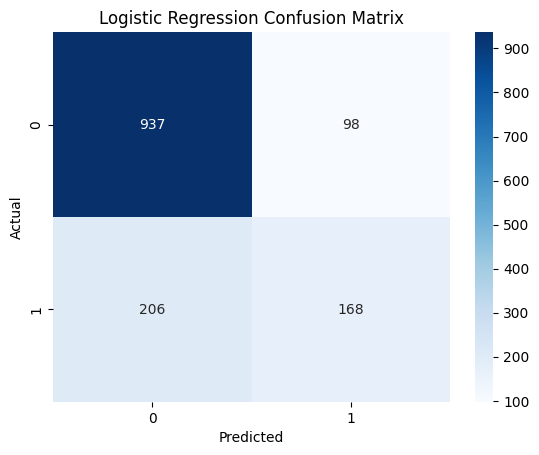

In [8]:
# Confusion matrix heatmap (Logistic Regression)
cm = log_results["confusion_matrix"]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [9]:
# ROC curve comparison (use models directly for probabilities)
y_prob_log = log_model.predict_proba(X_test)[:, 1]
y_prob_rf  = rf_model.predict_proba(X_test)[:, 1]

In [10]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)


In [11]:
rf_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [12]:
# Fitted pipeline already includes the preprocessor and classifier
rf_model.fit(X_train, y_train)

# 2. Get fitted preprocessor
preprocessor_fitted = rf_model.named_steps["preprocessor"]

# 3. Get all feature names using get_feature_names_out
# This works for both numeric and categorical features in a ColumnTransformer
try:
    feature_names = preprocessor_fitted.get_feature_names_out()
except:
    # fallback: combine numeric + categorical manually
    num_features = preprocessor_fitted.transformers_[0][2]
    cat_pipeline = preprocessor_fitted.transformers_[1][1]
    cat_encoder = cat_pipeline.named_steps["encoder"]
    cat_features = cat_encoder.get_feature_names_out(cat_pipeline.feature_names_in_)
    feature_names = list(num_features) + list(cat_features)




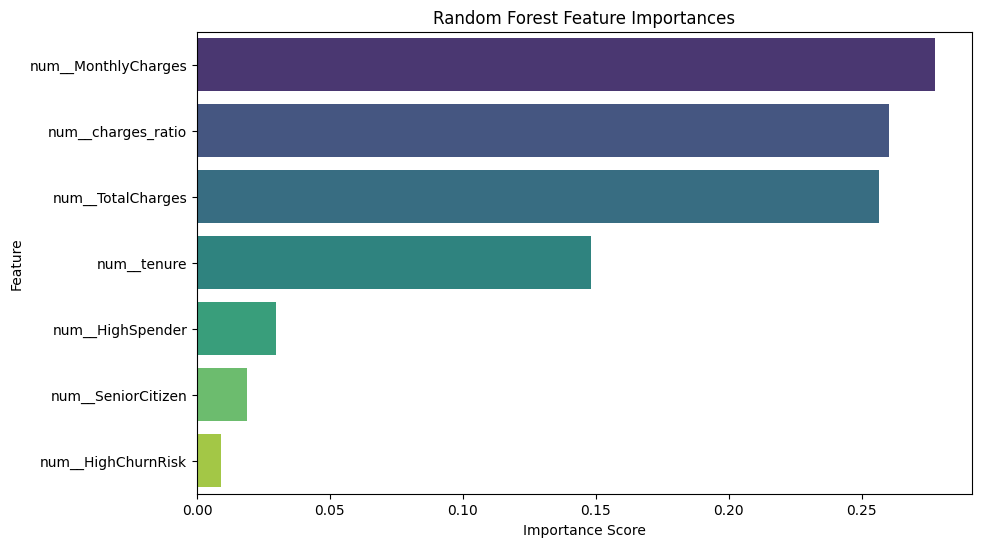

In [13]:

importances = rf_model.named_steps["classifier"].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances[indices],
    y=[feature_names[i] for i in indices],
    hue=[feature_names[i] for i in indices],  # assign y to hue
    palette="viridis",
    dodge=False,   # keep bars together
    legend=False   # remove legend
)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


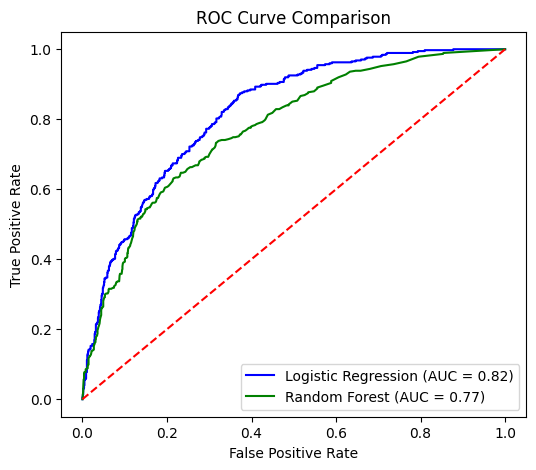

In [14]:
# ROC curves
plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, color="blue",  label=f"Logistic Regression (AUC = {roc_auc_log:.2f})")
plt.plot(fpr_rf,  tpr_rf,  color="green", label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


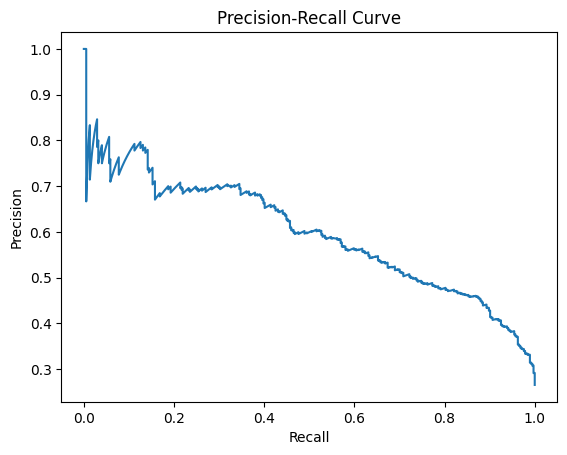

In [28]:
from sklearn.metrics import precision_recall_curve

def plot_pr(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)

    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()
    
plot_pr(y_test, y_prob_log)


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_log)

In [31]:
print("Precision-Recall thresholds:", thresholds)

Precision-Recall thresholds: [0.00338908 0.00375316 0.00389768 ... 0.83454916 0.83741942 0.86399264]


In [ ]:
print("Precision:", precision)
print("Recall:", recall)

Precision-Recall thresholds: [0.00338908 0.00375316 0.00389768 ... 0.83454916 0.83741942 0.86399264]
Precision: [0.26543648 0.265625   0.26581379 ... 1.         1.         1.        ]
Recall: [1.         1.         1.         ... 0.00534759 0.0026738  0.        ]


In [32]:
print(thresholds[1]) # → gives you the cutoff

print(precision[1])
print(recall[1]) # → what happens at that cutoff

0.0037531631317332674
0.265625
1.0


In [34]:
precision_adj = precision[:-1]
recall_adj = recall[:-1]

mask = (recall_adj >= 0.5) & (precision_adj >= 0.6)

optimal_threshold = thresholds[mask][0]


In [26]:
recall_20_log = recall_at_k(y_test, y_prob_log, k=0.2)
print("Logistic Regression Recall at 20%:", recall_20_log)


Logistic Regression Recall at 20%: 0.4572192513368984


In [25]:
recall_20_rf = recall_at_k(y_test, y_prob_rf, k=0.2)
print("Random Forest Recall at 20%:", recall_20_rf)

Random Forest Recall at 20%: 0.4385026737967914
